In [1]:
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm

from scipy.io import wavfile
from scipy.ndimage import maximum_filter
from scipy.interpolate import interp1d
import librosa

C:\Users\chris\anaconda3\envs\music\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
resolution = 8

In [3]:
# Turn On/Off Weights and Biases run uploads
wandb_online = True

# Turn On/Off Weights and Biases console logging during training. 
%env WANDB_SILENT=True

env: WANDB_SILENT=True


In [4]:
def generate_features(filename):
    # read wave file (this is faster than librosa.load)
    sample_rate, signal = wavfile.read(filename)

    # convert from integer to float
    if signal.dtype.kind == 'i':
        signal = signal / np.iinfo(signal.dtype).max

    # convert from stereo to mono (just in case)
    if signal.ndim == 2:
        signal = signal.mean(axis=-1)

    signal = librosa.resample(signal, orig_sr=sample_rate, target_sr=11025)
    sample_rate = 11025
    
    # compute spectrogram with given number of frames per second
    # hop_length_s = 0.025 # 25ms
    # window_length_s = 0.01 # 10ms
    #fps = 70
    #hop_length = sample_rate // fps
    spect = librosa.stft(
            signal, n_fft=1024, hop_length=1024//2, window='hamming')

    # only keep the magnitude
    magspect = np.abs(spect)

    # TODO: Impplement max filter for SuperFlux
    # magspect = maximum_filter(magspect, options.mfs)

    # compute a mel spectrogram
    melspect = librosa.feature.melspectrogram(
            S=magspect, sr=sample_rate, n_mels=40, fmin=20, fmax=5000)

    # compress magnitudes logarithmically
    # melspect = np.log1p(100 * melspect)
    
    return sample_rate, signal, spect, magspect, melspect

In [5]:
def interpolate_time(X, p):
    time_length = X.shape[1]
    interp_f = interp1d(np.arange(0,time_length), X, 'slinear')
    return interp_f(np.linspace(0, time_length-1, int(time_length*p))).astype(np.float32)

In [6]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, folder, deterministic=True, sample_per_file=1, resolution=resolution, seed=42):
        super().__init__()
        self.deterministic = deterministic
        self.rng = np.random.default_rng(seed)
        self.sample_per_file = sample_per_file
        self.resolution = resolution
        
        indir = Path(folder)
        audio_files = list(indir.glob('*.wav'))
        self.data = []
        for file in audio_files:
            spect = generate_features(file)[-1].astype(np.float32)
            with open(file.with_suffix('.tempo.gt'), 'r') as f:
                tempo = [float(value) for value in f.read().rstrip().split()]
            if self.deterministic:
                if spect.shape[1] < 256:
                    spect = np.pad(spect, [(0,0),(0,256-spect.shape[1])])
            #else:
            #    if len(tempo) == 3:
            #        tempo = tempo[0] if tempo[2] > 0.5 else tempo[1]
            #    else:
            #        tempo = tempo[0]
            #    tempo = np.int64(tempo)
            self.data.append((spect, tempo))
        
    def __getitem__(self, key):
        file_index = key//self.sample_per_file
        spect, tempi = self.data[file_index]
        if self.deterministic:
            return spect, tempi
        p = self.rng.uniform(0.8, 1.2)
        spect = interpolate_time(spect, p)
        if spect.shape[1] < 256:
            spect = np.pad(spect, [(0,0),(0,256-spect.shape[1])])
        crop = self.rng.integers(spect.shape[1]-256+1)
        
        if len(tempi) > 1 and self.rng.random() > tempi[2]:
            tempo = tempi[1]
        else:
            tempo = tempi[0]
        
        return spect[None, :,crop:crop+256], np.clip(np.round((tempo*p-30)/self.resolution).astype(np.int64), 0, 256//self.resolution)
    
    def __len__(self):
        return len(self.data)*self.sample_per_file

In [7]:
class ShortFilter(nn.Module):
    def __init__(self, in_channels=16):
        super().__init__()
        self.layers = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, 16, (1, 5), 1, 'same'),
            nn.ELU()
        )
        
    def forward(self, X):
        return self.layers(X)
    
class MultiFilter(nn.Module):
    def __init__(self, in_channels=36, pooling_size=2):
        super().__init__()
        self.preprocess = nn.Sequential(
            nn.AvgPool2d((pooling_size, 1)),
            nn.BatchNorm2d(in_channels)
        )
        self.cnns = nn.ModuleList([nn.Conv2d(in_channels, 24, (1, size), 1, 'same') for size in [32, 64, 96, 128, 192, 256]])
        self.bottleneck = nn.Conv2d(6*24, 36, 1, 1, 'same')
        
    def forward(self, X):
        X = self.preprocess(X)
        X = torch.cat([cnn(X) for cnn in self.cnns], axis=1)
        return self.bottleneck(X)

class TempoCNN(nn.Module):
    def __init__(self, output_size=256//resolution, window_size=256, bands=40):
        super().__init__()
        bottleneck_size = output_size//4
        self.layers = nn.Sequential(
            ShortFilter(1),
            ShortFilter(),
            ShortFilter(),
            MultiFilter(16, 5),
            MultiFilter(),
            MultiFilter(),
            MultiFilter(),
            nn.Flatten(),
            nn.BatchNorm1d(window_size*(bands//40)*36),
            nn.Dropout(0.5),
            nn.Linear(window_size*(bands//40)*36, bottleneck_size),
            nn.ELU(),
            nn.BatchNorm1d(bottleneck_size),
            nn.Linear(bottleneck_size, bottleneck_size),
            nn.ELU(),
            nn.BatchNorm1d(bottleneck_size),
            nn.Linear(bottleneck_size, output_size),
            nn.LogSoftmax(dim=-1)
        )
        
    def forward(self, X):
        return self.layers(X)

In [8]:
@torch.no_grad()
def make_pred(model, spect, threshold=10, resolution=resolution):
    X = np.lib.stride_tricks.sliding_window_view(spect, 256, 1).transpose(1, 0, 2)[::8, None, : ,:]
    X = torch.from_numpy(X).cuda()
    model.eval()
    preds = model(X).mean(0).cpu()
    sorted_tempos = preds.argsort(descending=True)
    main_tempo = sorted_tempos[0]
    for tempo in sorted_tempos:
        if abs(tempo - main_tempo) > threshold:
            secondary_tempo = tempo
            break
    return sorted([main_tempo.item()*resolution+30, secondary_tempo.item()*resolution+30])

In [9]:
import mir_eval
def eval_tempo(truth, preds):
    """
    Computes the average tempo estimation p-score.
    """
    def prepare_truth(tempi):
        if len(tempi) == 3:
            tempi, weight = tempi[:2], tempi[2]
        else:
            tempi, weight = [tempi[0] / 2., tempi[1]], 0.
        return np.asarray(tempi), weight

    def prepare_preds(tempi):
        if len(tempi) < 2:
            tempi = [tempi[0] / 2., tempi[0]]
        return np.asarray(tempi)
    
    return mir_eval.tempo.detection(*prepare_truth(truth),
                                    prepare_preds(preds),
                                    0.08)[0]

    #return sum(mir_eval.tempo.detection(*prepare_truth(truth[k]),
    #                                    prepare_preds(preds[k]),
    #                                    0.08)[0]
    #           for k in range(len(truth))) / len(truth)

In [10]:
def train(model, optimizer, loss_fn, ds):
    '''
    Subroutine to train the model by doing one pass over the provided dataset
    Returns the mean loss over batches
    '''
    model.train()
    losses = []
    for inp, target in ds:
        optimizer.zero_grad()
        target = target.cuda()
        inp = inp.cuda()
        pred = model(inp)
        loss = loss_fn(pred, target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    return np.mean(losses)
    
@torch.no_grad()
def validate(model, ds):
    '''
    Subroutine to evaluate the model by doing one pass over the provided dataset
    Returns the mean loss of the model on the dataset
    '''
    model.eval()
    values = []
    for inp, target in ds:
        pred = make_pred(model, inp)
        val = eval_tempo(target, pred)
        values.append(val)
    return np.mean(values)

class EarlyStopper():
    '''
    Class to provide early stopping
    Keeps track of the lowest achieved loss and the corresponding model
    Also uses a patience parameter to control how quickly the early stopper ends training
    '''
    
    def __init__(self, patience):
        self.patience = patience
        self.best = 0
        self.worse = 0
        self.best_model = None
        
    def __call__(self, val_value, model):
        if val_value < self.best:
            self.worse += 1
        else:
            self.best = val_value
            self.best_model = model.state_dict()
            self.worse = 0
        return self.worse == self.patience
    
def training_loop(model, optimizer, loss_fn, train_ds, val_ds, epochs, patience):
    '''
    Subroutine which optimizes a model over some number of epochs or until validation performance gets worse (early stopping)
    Tracks the optimizations using Weights & Biases
    Returns training and validation losses over all epochs
    '''
    
    wandb.init(
        project="AudioAndMusic",
        name='tempo_cnn',
        config=dict(batch_size=batch_size, epochs=epochs, patience=patience),
        mode='online' if wandb_online else 'offline',
        reinit=True
    )
    wandb.define_metric("epoch")
    wandb.define_metric("*", step_metric="epoch")
    wandb.watch(model, log_freq=len(train_ds))
    
    stopper = EarlyStopper(patience)
    train_losses = []
    val_losses = []
    with tqdm(range(epochs), desc='Training') as pbar:
        for epoch in pbar:
            train_loss = train(model, optimizer, loss_fn, train_ds)
            train_losses.append(train_loss)
            
            val_loss = validate(model, val_ds)
            val_losses.append(val_loss)
            
            wandb.log({'loss': train_loss, 'val_loss': val_loss, 'epoch': epoch})
            pbar.set_postfix(loss=train_loss, val_loss=val_loss)
            
            if stopper(val_loss, model):
                model.load_state_dict(stopper.best_model)
                print('Stopping early. Epoch:', epoch+1)
                break
    wandb.finish(quiet=True)
    return train_losses, val_losses

In [11]:
epochs = 100
patience = 10
batch_size = 64

In [12]:
train_dataset = AudioDataset('C:\\Users\\chris\\Downloads\\train_extra_tempobeats', deterministic=False, sample_per_file=16)
val_dataset = AudioDataset('train')

In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
model = TempoCNN().cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_fn = nn.NLLLoss()

model

TempoCNN(
  (layers): Sequential(
    (0): ShortFilter(
      (layers): Sequential(
        (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(1, 16, kernel_size=(1, 5), stride=(1, 1), padding=same)
        (2): ELU(alpha=1.0)
      )
    )
    (1): ShortFilter(
      (layers): Sequential(
        (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(16, 16, kernel_size=(1, 5), stride=(1, 1), padding=same)
        (2): ELU(alpha=1.0)
      )
    )
    (2): ShortFilter(
      (layers): Sequential(
        (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(16, 16, kernel_size=(1, 5), stride=(1, 1), padding=same)
        (2): ELU(alpha=1.0)
      )
    )
    (3): MultiFilter(
      (preprocess): Sequential(
        (0): AvgPool2d(kernel_size=(5, 1), stride=(5, 1), padding=0)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affin

In [15]:
train_losses, val_losses = training_loop(model, optimizer, loss_fn, train_loader, val_dataset, epochs, patience)

Training:   0%|                                                                                | 0/100 [00:00<?, ?it/s]C:\Users\chris\anaconda3\envs\music\lib\site-packages\torch\nn\modules\conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:883.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\chris\AppData\Local\Temp\ipykernel_2088\1648716443.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:178.)


Stopping early. Epoch: 16


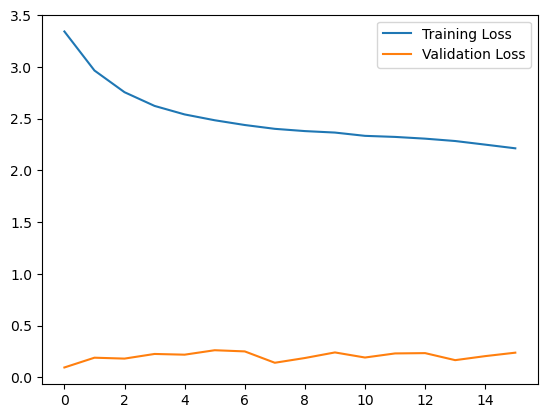

In [16]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [17]:
torch.save(model.state_dict(), 'tempo_model_3.pt')